In [3]:
# import libraries
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import category_encoders as ce 
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns 
import time
import warnings
from sklearn import tree
from sklearn import ensemble 
import hyperopt
from hyperopt import hp, tpe, fmin, Trials
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

In [4]:
# load data
train_data = pd.read_csv(r'C:\Users\79654\OneDrive\Desktop\Проекты на Kaggle\Результат\titanic\train.csv')
test_data = pd.read_csv(r'C:\Users\79654\OneDrive\Desktop\Проекты на Kaggle\Результат\titanic\test.csv')
id = test_data['PassengerId']

In [5]:
# feature engineering
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

for df in [train_data, test_data]:
    df['Title'] = df['Name'].apply(extract_title)
    rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize']==1).astype(int)
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    df['Deck'] = df['Cabin'].fillna('U').astype(str).str[0]
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']

age_medians = train_data.groupby('Title')['Age'].median()
train_data['Age'] = train_data.apply(lambda r: age_medians[r['Title']] if pd.isna(r['Age']) else r['Age'], axis=1)
test_data['Age'] = test_data.apply(lambda r: age_medians.get(r['Title'], test_data['Age'].median()) if pd.isna(r['Age']) else r['Age'], axis=1)


In [6]:
# detect and handle outliers
def outliers_iqr(data, feature):
    x = train_data[feature]
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - (iqr * 1.5)
    upper_bound = quantile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    clean = data[(x>lower_bound) & (x<upper_bound)]
    return outliers

outliers_train = outliers_iqr(train_data, 'Parch') 
outliers_test = outliers_iqr(test_data, 'Parch')
mask_parch_train = outliers_train[outliers_train['Parch']>3]
mask_parch_test = outliers_test[outliers_test['Parch']>2]

C:\Users\79654\AppData\Local\Temp\ipykernel_16200\3336281217.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = data[(x<lower_bound) | (x>upper_bound)]
C:\Users\79654\AppData\Local\Temp\ipykernel_16200\3336281217.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean = data[(x>lower_bound) & (x<upper_bound)]


In [7]:
# detect and handle missing values
train_data = train_data.drop(['Cabin', 'PassengerId', 'Name'], axis=1)
train_data['Age'] = train_data['Age'].fillna(float(24))
train_data = train_data.drop(mask_parch_train.index, axis=0)
train_data = train_data.dropna()


test_data = test_data.drop(['Cabin', 'PassengerId', 'Name'], axis=1)
test_data['Age'] = test_data['Age'].fillna(float(24))
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

In [8]:
# encode categorical features
encoder_onehot = ce.OneHotEncoder(cols=['Sex', 'Embarked', 'Title', 'Deck'])
sex_encoded = encoder_onehot.fit_transform(train_data[['Sex', 'Embarked', 'Title', 'Deck']])
train_data = train_data.drop(['Sex', 'Embarked', 'Title', 'Deck'], axis=1)
train_data = pd.concat([train_data, sex_encoded], axis=1)

encoder_binary = ce.BinaryEncoder(cols=['Ticket'])
ticket_encoded = encoder_binary.fit_transform(train_data['Ticket'])
train_data = train_data.drop(['Ticket'], axis=1)
train_data = pd.concat([train_data, ticket_encoded], axis=1)

encoder_onehot = ce.OneHotEncoder(cols=['Sex', 'Embarked', 'Title', 'Deck'])
sex_encoded = encoder_onehot.fit_transform(test_data[['Sex', 'Embarked', 'Title', 'Deck']])
test_data = test_data.drop(['Sex', 'Embarked', 'Title', 'Deck'], axis=1)
test_data = pd.concat([test_data, sex_encoded], axis=1)

encoder_binary = ce.BinaryEncoder(cols=['Ticket'])
ticket_encoded = encoder_binary.fit_transform(test_data['Ticket'])
test_data = test_data.drop(['Ticket'], axis=1)
test_data = pd.concat([test_data, ticket_encoded], axis=1)

In [9]:
# remove columns not present in test set to ensure matching dimensionality
train_data = train_data.drop(['Ticket_9', 'Title_7', 'Title_8', 'Title_9', 'Deck_9'], axis=1)

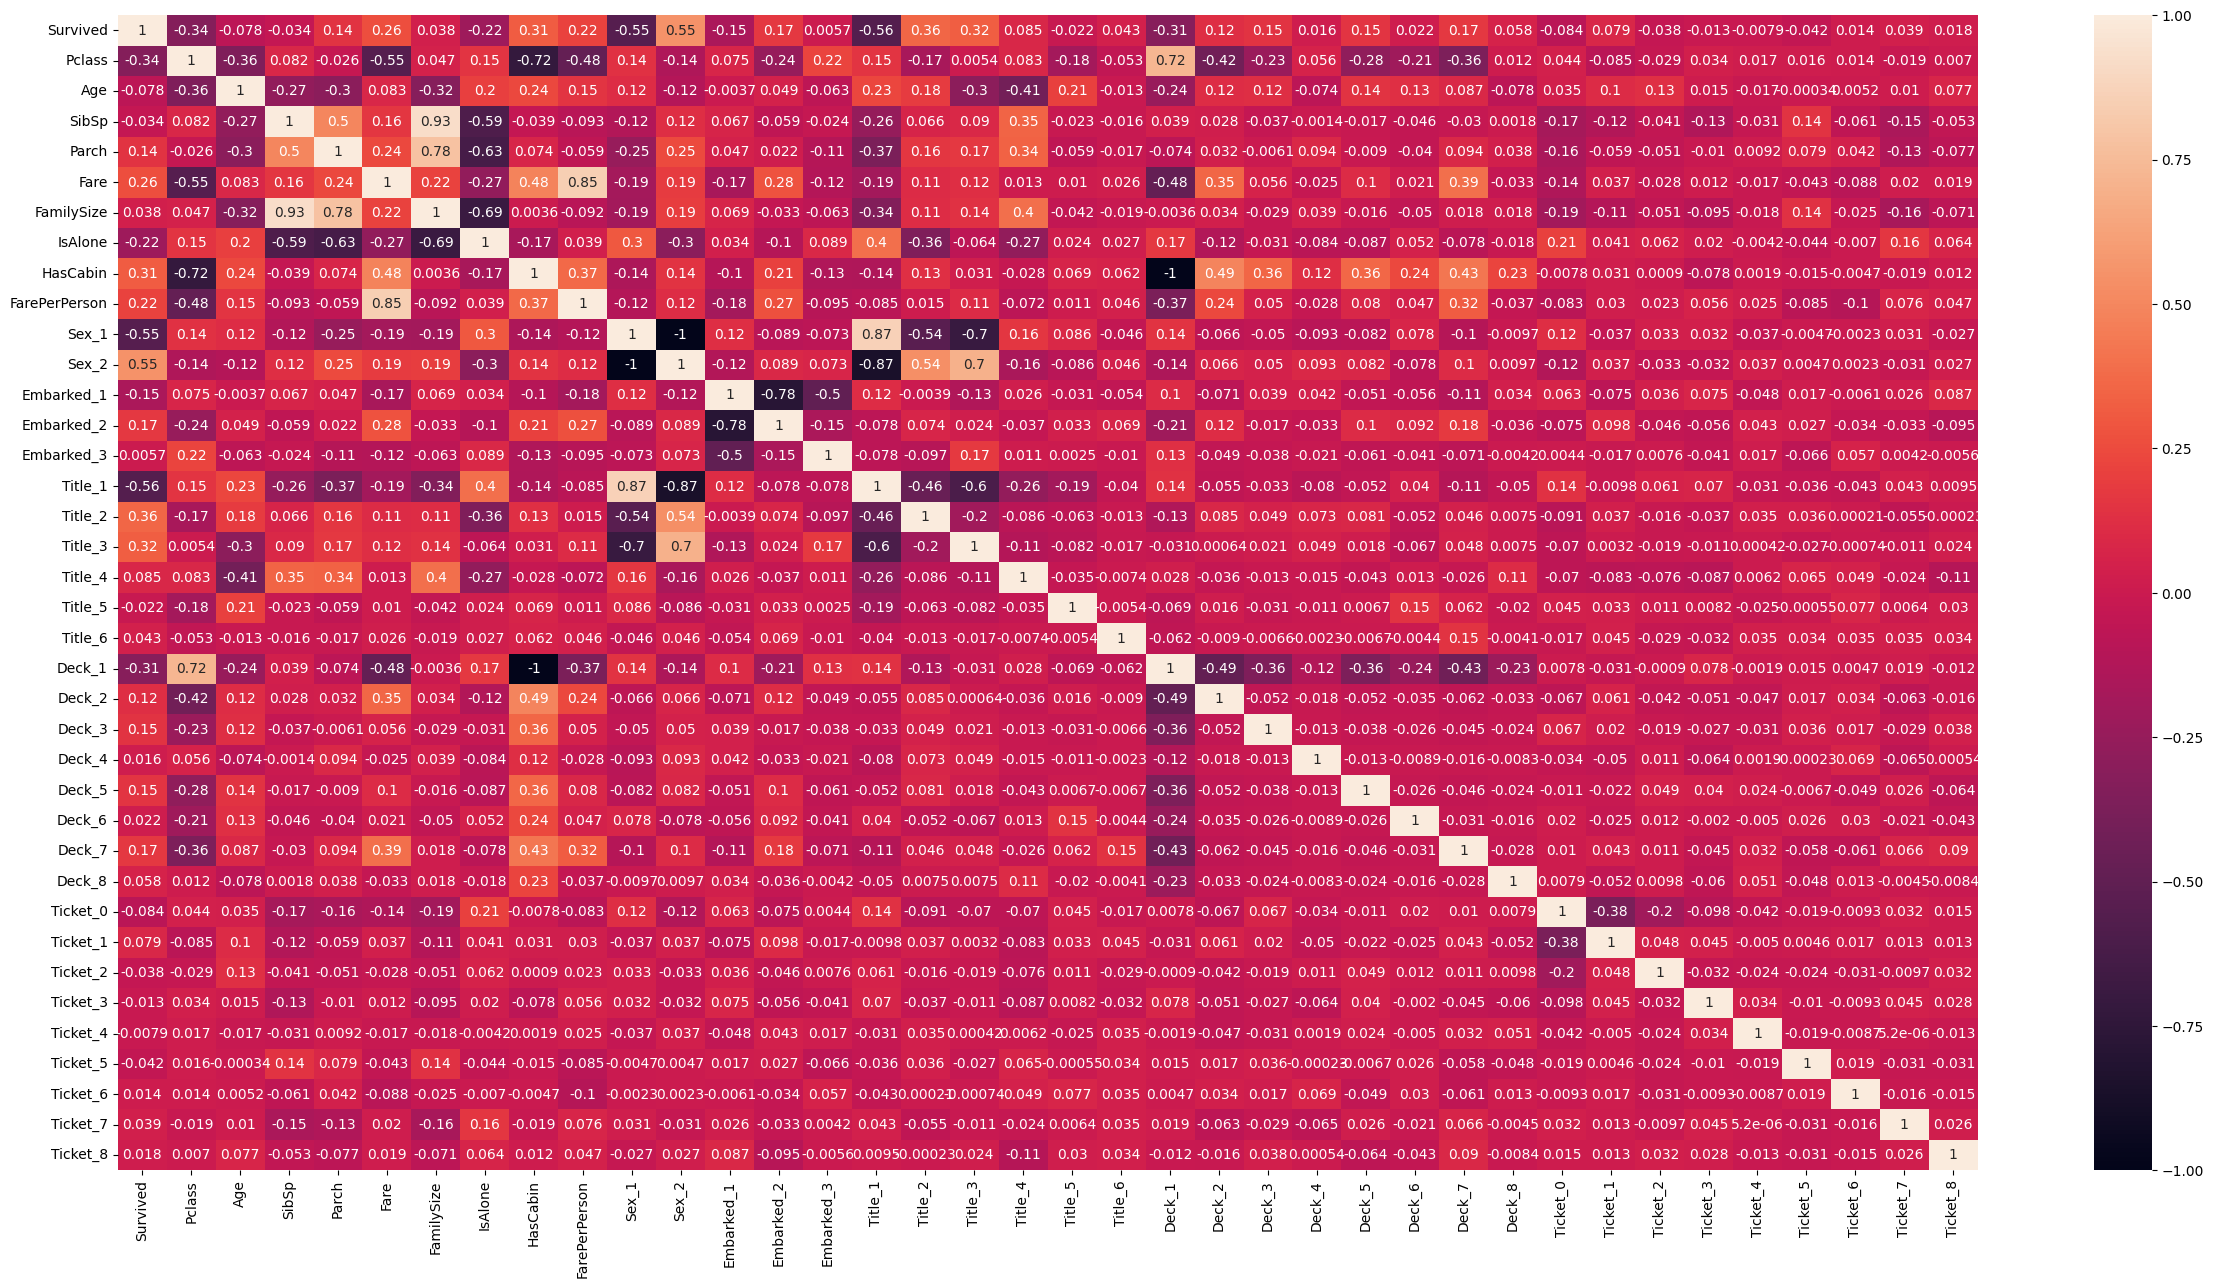

In [10]:
# examine correlation matrix
corr_matrix = train_data.corr()
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(train_data.corr(), annot=True, ax=ax)
plt.show()

In [11]:
# split data into training and test sets
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# perform hyperparameter tuning
from hyperopt import Trials
warnings.filterwarnings('ignore')

space = {'max_depth': hp.quniform('max_depth', 1, 7, 1),
         'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 100, 1),
         'criterion': hp.choice('criterion', ['entropy', 'gini']),
         'class_weight': hp.choice('class_weight', ['balanced', None])}

random_state = 42

def hyperopt_rf(params, random_state=random_state, X=X_train, y=y_train, cv=5):
    params = {'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf']),
              'criterion': params['criterion'],
              'class_weight': params['class_weight']}
    
    model = tree.DecisionTreeClassifier(**params, random_state=random_state)
    model.fit(X, y)
    
    score = metrics.f1_score(y, model.predict(X))
    
    return -score

Trials = Trials()

best = fmin(hyperopt_rf,
            max_evals=20,
            trials=Trials,
            space=space,
            rstate=np.random.default_rng(random_state))

print(best)

TPE is being used as the default algorithm.


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:00<00:00, 25.70trial/s, best loss: -0.8269581056466302]
{'class_weight': 1, 'criterion': 0, 'max_depth': 6.0, 'min_samples_leaf': 7.0}


In [14]:
# train decision tree model and evaluate metrics
tree_model = tree.DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=148)

tree_model.fit(X_train, y_train)

y_train_predict = tree_model.predict(X_train)
y_test_predict = tree_model.predict(X_test)
print(round(metrics.accuracy_score(y_train, y_train_predict), 3))
print(round(metrics.accuracy_score(y_test, y_test_predict), 3))

0.795
0.75


In [15]:
# validate model performance
kf = model_selection.KFold(n_splits=10)
cv_metrics = model_selection.cross_validate(
estimator=tree_model,
X=X,
y=y,
cv=kf, 
scoring='accuracy',
return_train_score=True
)

# find optimal threshold on validation set
cv_metrics['test_score'].min()

0.75

In [16]:
# generate final predictions
tree_model.fit(X, y)
result_predict = tree_model.predict(test_data)

In [17]:
# save results to CSV
result = pd.DataFrame({'PassengerId': id, 'Survived': result_predict})
result.to_csv('result.csv', index=False)